In [ ]:
!nvidia-smi

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# path = '.../Models/deepseek-hf/r1-7B'
path = ... # Path to DeepSeek-R1-Distill-Qwen-7B

tokenizer = AutoTokenizer.from_pretrained(path, padding_side="left")
tokenizer.pad_token_id = tokenizer.eos_token_id

model = AutoModelForCausalLM.from_pretrained(path, device_map='cuda:0')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Generate responses

In [14]:
import pandas as pd

df = pd.read_json('datasets/MATH-500-test.jsonl', lines=True)
df.head()

,problem,solution,answer,subject,level,unique_id
0,"Convert the point $(0,3)$ in rectangular coord...",We have that $r = \sqrt{0^2 + 3^2} = 3.$ Also...,"\left( 3, \frac{\pi}{2} \right)",Precalculus,2,test/precalculus/807.json
1,Define\n\[p = \sum_{k = 1}^\infty \frac{1}{k^2...,We count the number of times $\frac{1}{n^3}$ a...,p - q,Intermediate Algebra,5,test/intermediate_algebra/1994.json
2,"If $f(x) = \frac{3x-2}{x-2}$, what is the valu...",$f(-2)+f(-1)+f(0)=\frac{3(-2)-2}{-2-2}+\frac{3...,\frac{14}{3},Algebra,3,test/algebra/2584.json
3,How many positive whole-number divisors does 1...,First prime factorize $196=2^2\cdot7^2$. The ...,9,Number Theory,3,test/number_theory/572.json
4,The results of a cross-country team's training...,Evelyn covered more distance in less time than...,\text{Evelyn},Algebra,2,test/algebra/1349.json


In [8]:
import torch
from torch.amp import autocast

def decorate_prompts(tokenizer, prompts_raw):
    """
    Apply chat template (and add fix response prefix) to the prompts.
    """
    dialogs = [[{"role":"user", "content":prompt_raw}] for prompt_raw in prompts_raw]
    prompts = tokenizer.apply_chat_template(dialogs, tokenize=False, add_generation_prompt=True)

    return prompts

prompt_raw = df['problem'][0]
promtps = decorate_prompts(tokenizer, [prompt_raw])
inputs = tokenizer(promtps, return_tensors='pt', padding=True, add_special_tokens=False).to(model.device)
print(tokenizer.decode(inputs['input_ids'][0]))

<｜begin▁of▁sentence｜><｜User｜>Convert the point $(0,3)$ in rectangular coordinates to polar coordinates.  Enter your answer in the form $(r,\theta),$ where $r > 0$ and $0 \le \theta < 2 \pi.$<｜Assistant｜>


In [ ]:
from tqdm import tqdm
from torch.amp import autocast
from torch.utils.data import DataLoader

dataloader = DataLoader(df['problem'], batch_size=10, shuffle=False)

output_id_list = []
prompt_id_list = []
for idx, prompts_raw in enumerate(tqdm(dataloader)):

    prompts = decorate_prompts(tokenizer, prompts_raw)
    inputs = tokenizer(prompts, return_tensors='pt', padding=True, add_special_tokens=False).to(model.device)
    with autocast('cuda'):
        outputs = model.generate(
            **inputs,
            max_new_tokens=8192,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
        )

        masks = outputs.ne(tokenizer.eos_token_id)
        num_tokens = inputs['input_ids'].shape[1]
        for prompt_id, output_id, mask in zip(outputs, masks):
            prompt_id_list.append(prompt_id[mask[:num_tokens]].tolist())
            output_id_list.append(output_id[mask].tolist())

df_out = pd.DataFrame({'prompts':prompt_id_list, 'outputs':output_id_list})
df_out.to_parquet('datasets/outputs.parquet', index=False)

In [ ]:
# Filter the generations

df_out = pd.read_parquet('datasets/outputs.parquet')

prompt_id_list = []
output_id_list = []

responses = []
for prompt_id, output_id in zip(df_out['prompts'], df_out['outputs']):

    gen_len = len(output_id)-len(prompt_id)
    if gen_len<=4096:
        prompt_id_list.append(prompt_id)
        output_id_list.append(output_id)

df_out_filter = pd.DataFrame({'prompts':prompt_id_list, 'outputs':output_id_list})
df_out_filter.to_parquet('datasets/outputs_filter.parquet', index=False)

## Collect activations

In [46]:
import pandas as pd

df = pd.read_parquet('datasets/outputs_filter.parquet')

prompt_ids = df['outputs'][0]
print(tokenizer.decode(prompt_ids))

<｜begin▁of▁sentence｜><｜User｜>Convert the point $(0,3)$ in rectangular coordinates to polar coordinates.  Enter your answer in the form $(r,\theta),$ where $r > 0$ and $0 \le \theta < 2 \pi.$<｜Assistant｜><think>
Okay, so I need to convert the rectangular coordinate (0, 3) to polar coordinates. Hmm, I remember that polar coordinates are represented as (r, θ), where r is the radius or the distance from the origin to the point, and θ is the angle made with the positive x-axis. 

First, let me recall the formulas for converting rectangular coordinates (x, y) to polar coordinates (r, θ). I think r is calculated using the Pythagorean theorem, so r = sqrt(x² + y²). And θ is found using the arctangent function, θ = arctan(y/x). But wait, I also remember that sometimes arctan(y/x) isn't enough because it doesn't account for the correct quadrant. So, I need to consider the signs of x and y to determine the correct angle.

Looking at the point (0, 3), x is 0 and y is 3. Let me plug these into the 

In [47]:
# Check the pattern of the special tokens

bot_token_id = tokenizer('<think>', add_special_tokens=False)['input_ids'][0]
eot_token_id = tokenizer('</think>', add_special_tokens=False)['input_ids'][0]
print(bot_token_id, eot_token_id)

wait_pattern = tokenizer('A.\n\nWait, I.\n\nBut, I.\n\n**Final Answer**', add_special_tokens=False)['input_ids']
print(wait_pattern)

151648 151649
[32, 382, 14190, 11, 358, 382, 3983, 11, 358, 382, 334, 19357, 21806, 334]


In [ ]:
import torch
import numpy as np

def search_think_range(prompt_ids, bot_token_id=151648, eot_token_id=151649):
    start_pos = np.where(prompt_ids == bot_token_id)[0][0]
    try:
        end_pos = np.where(prompt_ids == eot_token_id)[0][0]
    except:
        end_pos = len(prompt_ids)

    return start_pos, end_pos

# Positive: **
# Negative: Wait/But

def search_pos(prompt_ids, pos_pattern=[382, 334], nega_patter=[[382, 14190], [382, 3983]]):
    start_pos, end_pos = search_think_range(prompt_ids)
    pos_pos_list = []
    nega_pos_list = []
    
    for pos in range(start_pos+1, end_pos):
        if (prompt_ids[pos-1:pos+1] == pos_pattern).all():
                pos_pos_list.append(pos)

        if prompt_ids[pos-1:pos+1].tolist() in nega_patter:
            nega_pos_list.append(pos)

    return pos_pos_list, nega_pos_list

prompt_ids = df['outputs'][1]
pos_pos_list, nega_pos_list = search_pos(prompt_ids)

print(pos_pos_list, nega_pos_list)
for pos in pos_pos_list[:5]:
    print(tokenizer.decode(prompt_ids[pos]))
for pos in nega_pos_list[:5]:
    print(tokenizer.decode(prompt_ids[pos]))

[977] [628, 701]
**
Wait
But


In [48]:
from tqdm import tqdm
from torch.amp import autocast
import random

# Extract Hidden States

pos_hidden_list = [[] for _ in range(model.config.num_hidden_layers)]
nega_hidden_list = [[] for _ in range(model.config.num_hidden_layers)]

for input_id in tqdm(df['outputs'][:200]):
    pos_pos_list, nega_pos_list = search_pos(input_id)

    if len(pos_pos_list)>5:
        pos_pos_list = random.sample(pos_pos_list, 5)
    if len(nega_pos_list)>5:
        nega_pos_list = random.sample(nega_pos_list, 5)

    input_ids = torch.tensor(input_id).to(model.device).unsqueeze(0)
    with torch.no_grad(), autocast('cuda'):
        outputs = model(input_ids, output_hidden_states=True)

    for layer_idx, hiddens in enumerate(outputs.hidden_states[1:]):
        for pos in pos_pos_list:
            pos_hidden_list[layer_idx].append(hiddens[:, pos-1].detach().clone())
        for pos in nega_pos_list:
            nega_hidden_list[layer_idx].append(hiddens[:, pos-1].detach().clone())

pos_hiddens = [torch.cat(hiddens, dim=0) for hiddens in pos_hidden_list]
nega_hiddens = [torch.cat(hiddens, dim=0) for hiddens in nega_hidden_list]

torch.save({'positive': pos_hiddens, 'negative':nega_hiddens}, 'datasets/hiddens.pt')

100%|██████████| 200/200 [00:40<00:00,  4.98it/s]


In [30]:
import torch

record = torch.load('datasets/hiddens.pt')
pos_hiddens = record['positive']
nega_hiddens = record['negative']

/tmp/ipykernel_1279992/2826695767.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  record = torch.load('datasets/hiddens.pt')


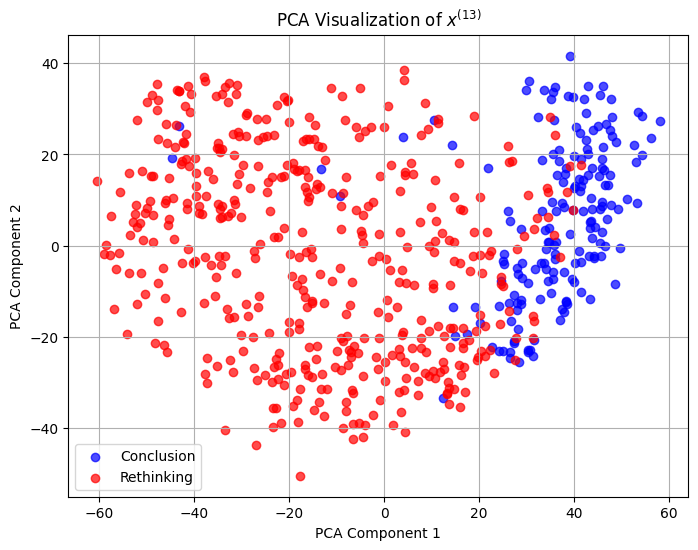

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Example tensors
layer_idx = 13
tensor1 = pos_hiddens[layer_idx]  # First dataset (n1 x d)
tensor2 = nega_hiddens[layer_idx]  # Second dataset (n2 x d)
n1 = tensor1.size(0)

# Convert to NumPy (ensure tensors are on CPU)
data1 = tensor1.cpu().numpy()
data2 = tensor2.cpu().numpy()

# Concatenate both datasets
data = np.vstack([data1, data2])

# Perform PCA (reduce to 2D)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data)

# Split back into original groups
pca_data1 = pca_result[:n1]  # First dataset
pca_data2 = pca_result[n1:]  # Second dataset

# Plot PCA results
plt.figure(figsize=(8, 6))
plt.scatter(pca_data1[:, 0], pca_data1[:, 1], color='blue', label='Conclusion', alpha=0.7)
plt.scatter(pca_data2[:, 0], pca_data2[:, 1], color='red', label='Rethinking', alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of $x^{(13)}$")
plt.legend()
plt.grid(True)
plt.show()

## Fix Input

In [41]:
from utils import HiddenAblation, HiddenPatch
from tqdm import tqdm
import random
from torch.amp import autocast

layer_idx = 17

pos_hidden_mean = pos_hiddens[layer_idx].mean(dim=0) 
nega_hidden_mean = nega_hiddens[layer_idx].mean(dim=0)
hidden_gap = pos_hidden_mean-nega_hidden_mean

target_pos = 1 # 0 for rethink inferences, 1 for conclusion inferences
modified_forward = HiddenAblation(model, hidden_gap) # Directional Ablation
# modified_forward = HiddenPatch(model, hidden_gap.view(1,1,-1), layer_idx=layer_idx) # Activation Addition (Re2Con)
# modified_forward = HiddenPatch(model, -hidden_gap.view(1,1,-1), layer_idx=layer_idx) # Activation Addition (Con2Re)

count = [0, 0]
responses = []

random.seed(0)
for idx in tqdm(range(200, len(df))):
    prompt_res_ids = df['outputs'][idx]

    pos_pos_list, nega_pos_list = search_pos(prompt_res_ids)

    if target_pos==0:
        target_pos_list = nega_pos_list
    else:
        target_pos_list = pos_pos_list

    if len(target_pos_list)==0:
        continue
    else:
        pos = random.choice(target_pos_list)

    input_ids = prompt_res_ids[:pos]
    input_ids = torch.tensor([input_ids]).to(model.device) # Could accelerate by batch processing

    with autocast('cuda'), modified_forward:
        outputs = model.generate(
            input_ids,
            attention_mask=torch.ones_like(input_ids, dtype=int),
            max_new_tokens=1,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
            )
        responses.append(outputs[0, input_ids.shape[1]:])

        output_id = outputs[0, input_ids.shape[1]]
        if output_id==14190 or output_id==3983: # Wait or But
            count[1] += 1
        else:
            count[0] += 1

print(layer_idx, count)    

  0%|          | 0/177 [00:00<?, ?it/s]

100%|██████████| 177/177 [00:28<00:00,  6.23it/s]

17 [51, 97]


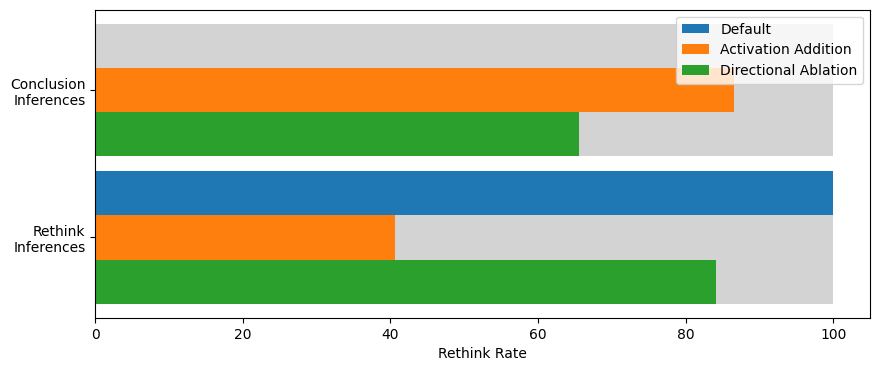

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Data
group1 = [1.0, 0.0]
group2 = [56/(82+56), 128/(20+128)]
group3 = [116/(22+116), 97/(51+97)] 

# Labels for the bars
bar_labels = ['Rethink\nInferences', 'Conclusion\nInferences']

# Positions of the bars on the x-axis
x = np.arange(len(bar_labels))

# Width of each bar
width = 0.3
# Create the plot
fig, ax = plt.subplots(figsize=(10, 4,))

# Create the bars
ax.barh(x, 100, 3*width, color='lightgray')
rects1 = ax.barh(x + width, 100*np.array(group1), width, label='Default')
rects2 = ax.barh(x, 100*np.array(group2), width, label='Activation Addition')
rects2 = ax.barh(x - width, 100*np.array(group3), width, label='Directional Ablation')

ax.set_xlabel('Rethink Rate')
ax.set_yticks(x)
ax.set_yticklabels(bar_labels)
ax.legend(loc=1)

plt.show()

## New Generation

In [ ]:
from utils import HiddenPatch, HiddenAblation

layer_idx = 17

pos_hidden_mean = pos_hiddens[layer_idx].mean(dim=0) 
nega_hidden_mean = nega_hiddens[layer_idx].mean(dim=0)
hidden_gap = pos_hidden_mean-nega_hidden_mean

# modified_forward = HiddenPatch(model, hidden_gap.view(1,1,-1), layer_idx=layer_idx)
modified_forward = HiddenAblation(model, hidden_gap)

prompt_id_list = []
response_id_list = []
for idx in range(200, len(df)):
    input_id = df['outputs'][idx]
    sot_pos, eot_pos = search_think_range(input_ids)
    print(eot_pos-sot_pos)

    input_ids = torch.tensor([input_id[:sot_pos+1]]).to(model.device)
    with autocast('cuda'), modified_forward:
        outputs = model.generate(
            input_ids=input_ids,
            max_new_tokens=4095,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
            )
        sot_pos, eot_pos = search_think_range(outputs[0].cpu().numpy())
        # print(eot_pos-sot_pos)
        output_id = outputs[0].tolist()
        prompt_id_list.append(output_id[:sot_pos])
        response_id_list.append(output_id[sot_pos:])

df_new = pd.DataFrame({'prompts': prompt_id_list, 'responses':response_id_list})
df_new.to_parquet('results/directional_ablation.parquet', index=False)

In [49]:
record_list = ['results/default.parquet', 'results/activation_addition_r2c.parquet', 'results/activation_addition_c2r.parquet', 'results/directional_ablation.parquet', ]

gen_len_list = []
for record_path in record_list:
    df = pd.read_parquet(record_path)
    
    count = 0
    for output_id in df['responses']:
        sot_pos, eot_pos = search_think_range(output_id)
        gen_len = eot_pos-sot_pos
        count += gen_len
    gen_len_list.append(count/len(df))

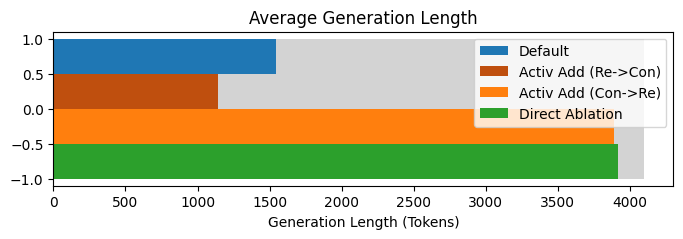

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

max_value = 4096  # Assume full scale is 100
y = np.array([0])  # Single group

# Width of each bar
height = 0.5

# Create the plot
fig, ax = plt.subplots(figsize=(8, 2))

# Plot background (full height for the group)
ax.barh(y, [max_value], 4*height, color='lightgray')

# Plot individual bars on top of the background
for idx, (r, c, n) in enumerate(zip(gen_len_list, ["#1f77b4", "#bf4f0e", "#ff7f0e", "#2ca02c"], ['Default', 'Activ Add (Re->Con)', 'Activ Add (Con->Re)', 'Direct Ablation'])):
    ax.barh(y-(idx-1.5)*height, [r], height, color=c, label=n)

# Add labels, title, and custom y-axis tick labels
ax.set_xlabel('Generation Length (Tokens)')
ax.set_title('Average Generation Length')
ax.legend()

# Display the plot
plt.show()
